In [37]:
%matplotlib inline

### Runing the script:

In [51]:
from PorousMediaLab import PorousMediaLab
import numpy as np

# Setting up the properties of time and space domain:
t = 12/12
dx = 0.1
L = 10
phi = 0.8
dt = 1e-5
x = np.linspace(0, L, L / dx + 1)

# Not simple initial concentration of solid iron:
Fe3_init = np.zeros(x.size)
Fe3_init[x > 1] = 75
Fe3_init[x > 2] = 0
Fe3_init[x > 3] = 75
Fe3_init[x > 4] = 0

# Create the domain:
ftc = PorousMediaLab(L, dx, t, dt, phi)

# Simulate Temperature with thermal diffusivity coefficient 281000 and init temperature 5C:
ftc.add_temperature(D=281000 / 10**4, init_temperature=5)

# Adding species with names, diffusion coefficients, initial concentrations and boundary top and bottom conditions:
ftc.add_species(is_solute=True, element='O2', D=368, init_C=0, bc_top=0.231, bc_top_type='dirichlet', bc_bot=0, bc_bot_type='flux')
ftc.add_species(is_solute=True, element='Fe2', D=127, init_C=0, bc_top=0, bc_top_type='flux', bc_bot=0, bc_bot_type='flux')
ftc.add_species(is_solute=False, element='OM', D=5, init_C=15, bc_top=0, bc_top_type='flux', bc_bot=0, bc_bot_type='flux')
ftc.add_solid_species('FeOH3', 5, Fe3_init, 0)

# Specify the constants used in the rates:
ftc.constants['Q10'] = 4
ftc.constants['k_OM'] = 1
ftc.constants['Km_O2'] = 20e-3
ftc.constants['Km_FeOH3'] = 10
ftc.constants['k8'] = 1.4e+5

# Specify the equations for rates:
ftc.rates['R1'] = 'Q10**((Temperature-5)/10) * k_OM * OM * O2 / (Km_O2 + O2)'
ftc.rates['R2'] = 'Q10**((Temperature-5)/10) * k_OM * OM * FeOH3 / (Km_FeOH3 + FeOH3) * Km_O2 / (Km_O2 + O2)'
ftc.rates['R8'] = 'k8 * O2 * Fe2'

# ODEs for specific species:
ftc.dcdt['OM'] = '-R1-R2'
ftc.dcdt['O2'] = '-R1-R8'
ftc.dcdt['FeOH3'] = '-4*R2+R8'
ftc.dcdt['Fe2'] = '-R8+4*R2'

# Because we are changing the boundary conditions for temperature and Oxygen (when T < 0 => no oxygen at the top), then we
# need to have a time loop:
for i in range(1, len(ftc.time)):

    # Thawing period: 5C + sin function changes during 1 day
    ftc.Temperature.bc_top = 20 * np.sin(np.pi * 2 * ftc.time[i]) + 5 * np.sin(np.pi * 2 * ftc.time[i] * 365)

    # when T < 0 => no oxygen at the top:
    if ftc.Temperature.bc_top < 0:
        ftc.O2.bc_top = 0
    else:
        ftc.O2.bc_top = 0.231

    # Integrate one timestep:
    ftc.integrate_one_timestep(i)

### Concentrations of different species during the whole period of simulation:

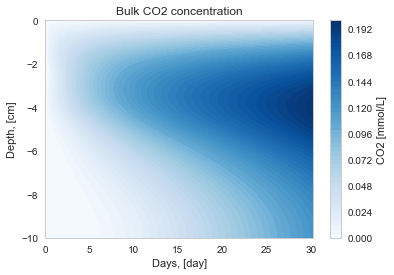

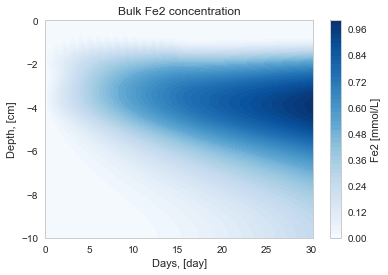

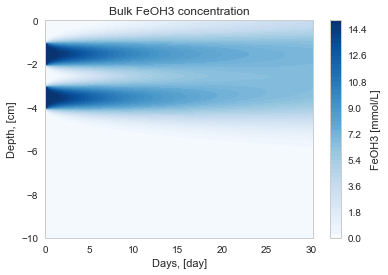

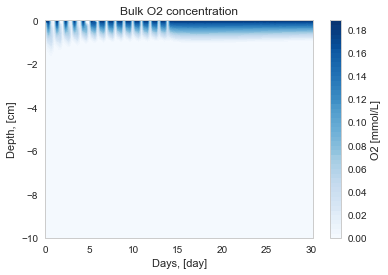

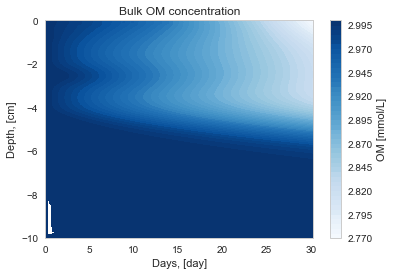

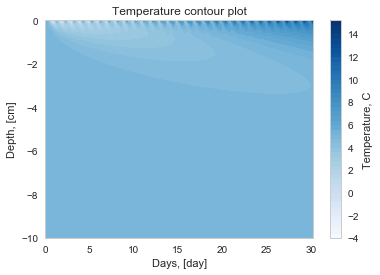

In [52]:
ftc.plot_contourplots()

### The rates of consumption and production of species:

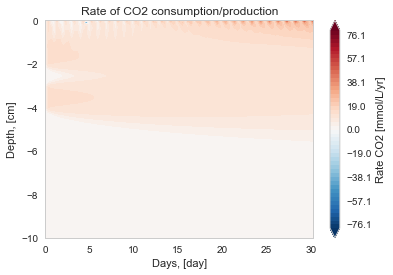

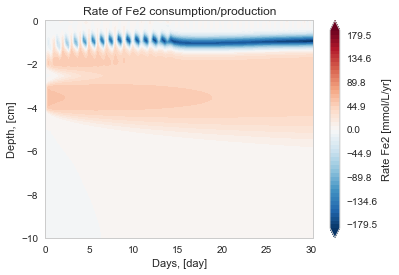

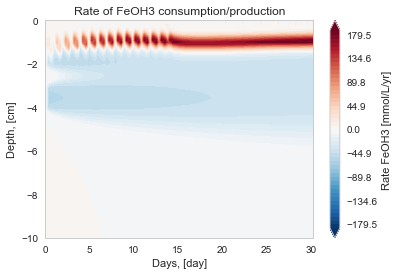

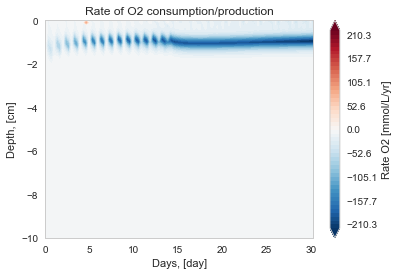

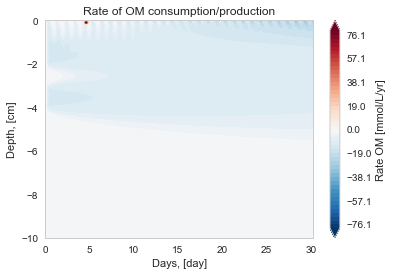

In [53]:
ftc.plot_contourplots_of_rates()

### Temperature timeseries at diferent depths:

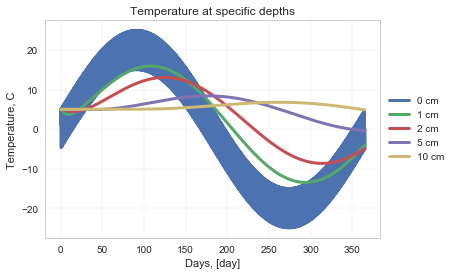

In [44]:
ftc.plot_depths("Temperature",[0,1,2,5,10])

### Temperatrure profiles during Freezing and Thawing cycles:

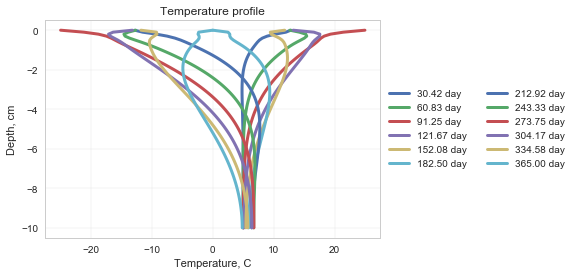

In [50]:
t1 = np.linspace(1,12,12)/12
# t2 = np.linspace(2,3,5)/12
times = np.concatenate((t1,))
ftc.plot_times('Temperature', times)

### Profiles at the end of the simulation

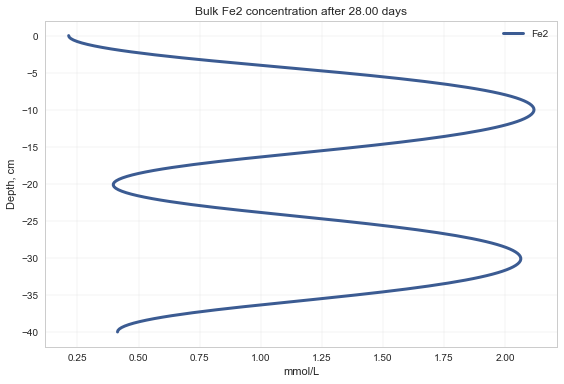

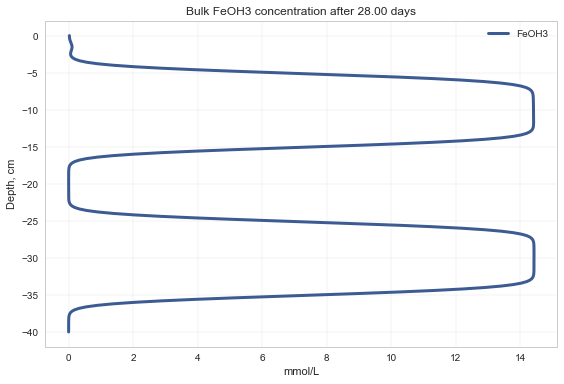

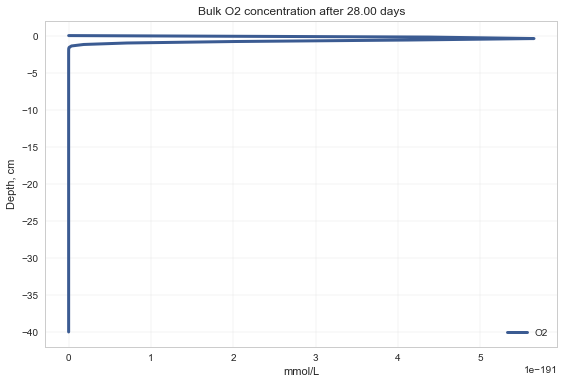

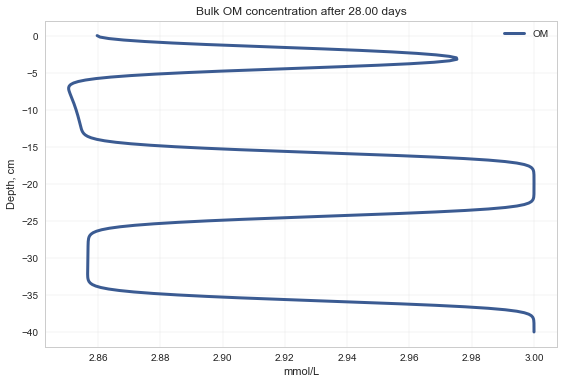

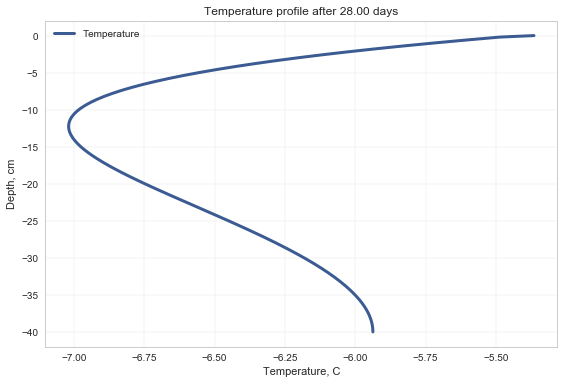

In [7]:
ftc.plot_profiles()